In [1]:
#pip install natsort
import pandas as pd
import numpy as np
import natsort # 파일 숫자 정렬용 라이브러리
import os
import librosa

## 0. MFCC 코드

In [84]:
#https://www.analyticsvidhya.com/blog/2022/03/implementing-audio-classification-project-using-deep-learning/
#https://stackoverflow.com/questions/52841335/how-can-i-pad-wav-file-to-specific-length
from librosa.util import fix_length
from librosa import load
from tqdm import tqdm

def features_extractor(file):
    #load the file (audio)
    file_name = file
    sf = 44100 # sampling frequency of wav file
    
    audio, sample_rate = librosa.load(file_name, sr=sf, mono=True) # mono=True converts stereo audio to mono
        
    #we extract mfcc'
    mfccs_features = librosa.feature.mfcc(y=audio, n_mfcc=20, sr=sf) ## --> n_mfcc : 20 ~ 50
    #print("mfccs_features",mfccs_features.shape)

    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0) ## 평균으로 출력
    
    #print("mfccs_scaled_features", mfccs_scaled_features.shape)
    return mfccs_scaled_features

## 1. feature 데이터 가공하기

In [85]:
file_list = natsort.natsorted(os.listdir("music3_audio_wav"))

extracted_features=[]
extracted_len_features=[]
file_total_len = 1 # feature_input 길이 ex). 1초, 2초

start_sec = 5 # 파일 갯수 정하기 ex 1 ~ 24
end_sec = 472
count = 0

for filename in file_list[start_sec-1:end_sec]:
    file_name = os.path.join("music3_audio_wav", filename) ## 만약에 2초마다 붙이고 싶으면
    # print(file_name)
    data = features_extractor(file_name)
    extracted_len_features = np.concatenate((extracted_len_features, data))
    count+=1
    
    if (count == file_total_len):
        extracted_features.append(extracted_len_features)
        
        extracted_len_features=[]
        count = 0

    
extracted_features_df=pd.DataFrame(extracted_features)

for column_name in extracted_features_df:
    extracted_features_df.rename(columns={column_name:"f"+str(column_name+1)},inplace=True)


## 2. skeleton 데이터 가공하기

In [86]:
skeleton = pd.read_csv('music3_hand_result.csv')

extracted_skeleton=[] ### 궁금한게 초 길이 ## 다음 순차적으로 데이터 이어 붙이기 해야할 것같음

interval = 1
start_frame = (start_sec+interval) * 30 # 실제 csv : ( row = 2부터 시작 ) // 한 칸씩 떼기
end_frame = (end_sec+interval) * 30

frame_count = 30 # 1초 = 30 frame

skeleton_col = ['INDEX_FINGER_PIP_LX'] # 원하는 column 에 대해서만 ex. 6번 = INDEX_FINGER_PIP_LX

for frame_num in range(start_frame, end_frame + 1, frame_count): # start_frame ~ end_frame
    extracted_total_skeleton=[]
    for col in skeleton_col:
        extracted_skeleton_list = list(skeleton.loc[frame_num:(frame_num+frame_count)-1, col])
        extracted_total_skeleton = np.concatenate((extracted_total_skeleton, extracted_skeleton_list))
    extracted_skeleton.append(extracted_total_skeleton)

extracted_skeleton_df = pd.DataFrame(extracted_skeleton)

for column_name in extracted_skeleton_df:
    extracted_skeleton_df.rename(columns={column_name:"s"+str(column_name+1)},inplace=True)

In [87]:
total_data = pd.concat([extracted_features_df, extracted_skeleton_df],axis=1)
total_data

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,s21,s22,s23,s24,s25,s26,s27,s28,s29,s30
0,-1131.370728,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,624.980011,624.515686,625.626717,626.742325,627.196388,628.167343,629.288254,0.000000,0.000000,0.000000
1,-1131.370728,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,741.540604,740.039139,738.791885,741.518402,965.318375,969.375534,968.527985,971.133652,974.208984,977.286148
2,-600.161072,83.292892,-0.855606,-6.247252,9.514754,1.260838,-3.974618,-1.122937,-2.315084,-0.782426,...,986.818085,990.895920,992.306366,992.766876,748.146439,751.155319,0.000000,0.000000,747.904053,748.794479
3,-314.307526,294.265228,-18.235453,-43.241116,23.966576,1.268239,-17.122757,-0.672371,-0.464282,-2.445030,...,1016.501160,762.037048,757.047043,1000.429916,997.305298,747.657471,0.000000,991.153412,993.239441,1000.373993
4,-286.899841,295.656647,-25.355766,-38.542938,30.198391,-1.347459,-17.192017,3.857743,2.328808,1.493181,...,982.200012,978.328552,974.822617,968.667984,966.926193,941.512299,964.371872,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,-499.660553,226.774216,24.239323,-34.519707,-4.645311,-6.661662,-24.467012,-17.183765,-8.609711,-11.367735,...,676.137314,553.682327,552.782555,552.999458,676.048203,675.833435,675.321121,675.325851,675.530701,675.846405
464,-519.125061,196.360794,20.975153,-37.906445,-8.972572,-2.429075,-21.040472,-20.170307,-9.023230,-9.146351,...,688.920212,689.198761,690.185700,689.881744,688.283386,688.633118,689.013825,689.306183,689.485626,689.206009
465,-664.719604,237.568832,34.023125,-27.980137,4.174069,5.959048,-15.679664,-12.246822,-1.270034,-7.274833,...,687.667694,687.689285,687.410126,688.717880,689.070664,689.700165,690.522080,690.021896,691.720810,691.699905
466,-642.387573,211.626724,58.024738,-17.231331,-9.627137,5.180705,-0.984878,-5.853268,-4.523614,-8.410495,...,689.105835,686.911392,686.934891,686.820145,686.609802,688.552475,689.970245,688.107758,687.123413,687.262878


In [23]:
total_data.to_csv("music3_combine.csv")

## 3. Train, Test 데이터 생성

In [2]:
import pandas as pd
total_data = pd.read_csv('music1_combine.csv')

In [3]:
total_data.drop('Unnamed: 0', inplace=True, axis=1)

In [4]:
f_list = []
s_list = []
for col in total_data.columns:
    if (col.find("f")!=-1):
        f_list.append(col)
    else:
        s_list.append(col)

In [5]:
total_data[f_list]

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20
0,-547.593689,182.509781,37.937355,-16.846518,-1.391793,1.324837,-13.556573,-13.167284,-4.734851,-6.718322,-9.740621,-5.135675,-1.817854,0.648492,10.452963,22.252068,26.023401,20.189854,8.526168,-4.872424
1,-507.154694,211.744293,33.218487,-26.411655,-1.870330,0.262763,-18.933554,-16.659975,-6.189260,-10.167423,-14.620936,-5.099606,5.729527,6.860226,6.661305,8.743710,4.979383,-2.161509,-1.549841,7.296625
2,-459.179321,202.464020,22.484058,-27.674269,-2.358259,-3.913093,-14.265837,-8.834578,-8.871878,-13.530530,-9.774071,-2.737972,3.329099,7.047334,3.436587,-3.383166,-5.223750,-2.935585,0.966473,6.561872
3,-446.630707,211.374664,12.299100,-33.203548,-3.327186,-11.966246,-24.265993,-12.778261,-8.485260,-10.596910,-1.406971,8.347066,7.223058,5.328804,10.233592,14.152901,12.203748,7.985044,1.749821,-5.613983
4,-446.797424,197.102905,14.067634,-33.141449,-8.750937,-13.869657,-21.842527,-10.863059,-10.585892,-13.653010,0.987512,17.324976,19.423326,15.015858,11.000606,5.888071,-0.155979,-3.658181,-3.294714,-1.952312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,-446.050049,205.589142,38.675037,-15.331746,2.986138,1.915448,-6.244214,0.229696,-1.608323,-11.757938,-10.526217,-0.839459,7.541202,13.301136,13.263604,6.809753,-0.164429,-4.641811,-6.758013,-5.673954
97,-494.663086,191.324509,47.311974,-17.356077,-5.341651,8.769717,5.758621,0.095020,-7.843935,-15.699287,-15.175900,-9.511230,-3.471454,4.813599,11.151368,10.853861,9.879621,11.573814,9.332519,-0.968077
98,-509.221405,215.682022,56.668644,-14.148309,0.933922,13.958107,2.396498,-5.233406,-5.611128,-10.041040,-13.921455,-12.012937,-8.293373,-3.318115,4.493851,10.750126,11.416161,8.333570,3.437935,-4.296869
99,-583.430786,274.856201,48.436287,-28.874844,-1.393196,22.851460,17.717361,7.890608,3.802971,-5.285686,-13.385489,-11.506063,-9.322365,-11.839654,-11.117025,-2.827772,5.236058,4.433934,-0.052048,-1.538372


In [6]:
def train_test_normalize(total_data):
    # create training and test set 
    
    inputs = total_data[f_list]
    outputs = total_data[s_list]
    
    ### Train Test Split
    from sklearn.model_selection import train_test_split
    X_train,X_test,y_train,y_test=train_test_split(inputs,outputs,test_size=0.2,random_state=7)
    
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)
    
    X_train, y_train = np.array(X_train), np.array(y_train) # 2차원 변경
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1 )) # LSTM 모델을 위해 3차원 변경
    
    X_test, y_test = np.array(X_test), np.array(y_test) # 2차원 변경
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 )) # LSTM 모델을 위해 3차원 변경
    
    return X_train, y_train , X_test, y_test

In [7]:
X_train, y_train, X_test, y_test = train_test_normalize(total_data)
print("X_train : ",X_train.shape, " y_train : ", y_train.shape)
print("X_test : ", X_test.shape, " y_test : ", y_test.shape)

(80, 20)
(80, 30)
(21, 20)
(21, 30)
X_train :  (80, 20, 1)  y_train :  (80, 30)
X_test :  (21, 20, 1)  y_test :  (21, 30)


## 4. LSTM 모델

In [8]:
def LSTM_model(X_train, y_train, X_test):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from keras import optimizers
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 50, 
                           return_sequences = True, 
                           input_shape = (X_train.shape[1],1), 
                           activation = 'relu'))
    my_LSTM_model.add(LSTM(units = 50, activation = 'relu')) # units = 50
    my_LSTM_model.add(Dense(units=30))
    
    # Compiling 
    my_LSTM_model.compile(loss='mae', optimizer='adam')

    my_LSTM_model.summary()
    
    #my_LSTM_model.fit(X_train, y_train, epochs = 50, batch_size = 150, verbose = 0)
    #LSTM_prediction = my_LSTM_model.predict(X_test)
    
    
    return my_LSTM_model
    


In [9]:
def LSTM_model_Run(X_train, y_train, X_test, LSTM_model):
    
    from tensorflow.keras.callbacks import EarlyStopping

    # model training
    batch_size = 512
    epoch = 10000
    
    early_stop = EarlyStopping(monitor='loss', patience=30, verbose=1)
    
    # Fitting to the training set 
    LSTM_model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, verbose=1, callbacks=[early_stop])
    
    LSTM_prediction = my_LSTM_model.predict(X_test)
    return LSTM_prediction

In [25]:
def actual_pred_plot(preds):
    
    actual_pred = pd.DataFrame(columns = ['actual_value', 'prediction'])
    actual_pred['actual_value'] = y_test[:, 0]
    actual_pred['prediction'] = preds[:,0]

    import tensorflow as tf
    
    m = tf.keras.metrics.MeanSquaredError()
    m.update_state(np.array(actual_pred['actual_value']), np.array(actual_pred['prediction']))
    
    
    return (m.result().numpy(), actual_pred.plot())

In [11]:
my_LSTM_model = LSTM_model(X_train, y_train, X_test)

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
Total params: 32,130
Trainable params: 32,130
Non-trainable params: 0
_________________________________________________________________


In [12]:
LSTM_prediction = LSTM_model_Run(X_train, y_train, X_test,my_LSTM_model)

Epoch 1/10000
80/80 [==============================] - 1s 16ms/step - loss: 650.0747
Epoch 2/10000
80/80 [==============================] - 0s 304us/step - loss: 640.2407
Epoch 3/10000
80/80 [==============================] - 0s 282us/step - loss: 639.8470
Epoch 4/10000
80/80 [==============================] - 0s 287us/step - loss: 639.6683
Epoch 5/10000
80/80 [==============================] - 0s 287us/step - loss: 639.4454
Epoch 6/10000
80/80 [==============================] - 0s 295us/step - loss: 639.1271
Epoch 7/10000
80/80 [==============================] - 0s 298us/step - loss: 638.6206
Epoch 8/10000
80/80 [==============================] - 0s 297us/step - loss: 637.8273
Epoch 9/10000
80/80 [==============================] - 0s 283us/step - loss: 636.5413
Epoch 10/10000
80/80 [==============================] - 0s 293us/step - loss: 634.3164
Epoch 11/10000
80/80 [==============================] - 0s 285us/step - loss: 631.0584
Epoch 12/10000
80/80 [==============================]

Epoch 96/10000
80/80 [==============================] - 0s 259us/step - loss: 139.3427
Epoch 97/10000
80/80 [==============================] - 0s 266us/step - loss: 138.5363
Epoch 98/10000
80/80 [==============================] - 0s 284us/step - loss: 137.5400
Epoch 99/10000
80/80 [==============================] - 0s 258us/step - loss: 136.5313
Epoch 100/10000
80/80 [==============================] - 0s 240us/step - loss: 135.4394
Epoch 101/10000
80/80 [==============================] - 0s 273us/step - loss: 134.5413
Epoch 102/10000
80/80 [==============================] - 0s 457us/step - loss: 133.6836
Epoch 103/10000
80/80 [==============================] - 0s 349us/step - loss: 132.7088
Epoch 104/10000
80/80 [==============================] - 0s 379us/step - loss: 131.7137
Epoch 105/10000
80/80 [==============================] - 0s 335us/step - loss: 131.2493
Epoch 106/10000
80/80 [==============================] - 0s 289us/step - loss: 130.1491
Epoch 107/10000
80/80 [=============

Epoch 190/10000
80/80 [==============================] - 0s 248us/step - loss: 126.8595
Epoch 191/10000
80/80 [==============================] - 0s 234us/step - loss: 126.0328
Epoch 192/10000
80/80 [==============================] - 0s 249us/step - loss: 125.7995
Epoch 193/10000
80/80 [==============================] - 0s 258us/step - loss: 125.5276
Epoch 194/10000
80/80 [==============================] - 0s 239us/step - loss: 125.1515
Epoch 195/10000
80/80 [==============================] - 0s 240us/step - loss: 125.0513
Epoch 196/10000
80/80 [==============================] - 0s 248us/step - loss: 124.3862
Epoch 197/10000
80/80 [==============================] - 0s 235us/step - loss: 124.3772
Epoch 198/10000
80/80 [==============================] - 0s 252us/step - loss: 123.5777
Epoch 199/10000
80/80 [==============================] - 0s 248us/step - loss: 123.2759
Epoch 00199: early stopping


In [32]:
LSTM_prediction[:,0]

array([663.1839 , 639.02924, 635.9651 , 715.7619 , 657.3434 , 632.97736,
       681.3749 , 660.6356 , 738.8999 , 681.5535 , 612.1024 , 658.51385,
       638.96564, 620.4443 , 786.6711 , 676.97595, 587.2402 , 624.608  ,
       644.01056, 651.0929 , 662.3475 ], dtype=float32)

([<matplotlib.axis.XTick at 0x232d04e7648>,
 <a list of 20 Text xticklabel objects>)

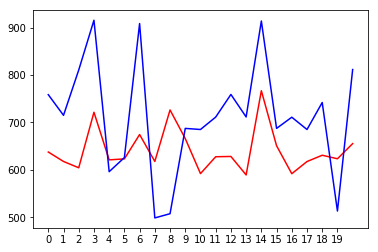

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(LSTM_prediction[:,1], 'r-')
plt.plot(y_test[:,1], 'b-')
plt.xticks(np.arange(0,20,1))

([<matplotlib.axis.XTick at 0x232d056e108>,
 <a list of 20 Text xticklabel objects>)

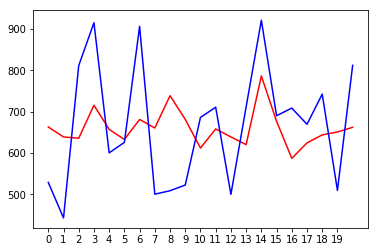

In [40]:
plt.plot(LSTM_prediction[:,0], 'r-')
plt.plot(y_test[:,0], 'b-')
plt.xticks(np.arange(0,20,1))

## 5. 정확도 계산

### 5-1. 그래프 비교

(19455.16, <matplotlib.axes._subplots.AxesSubplot at 0x232d0000648>)

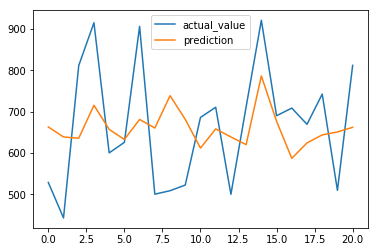

In [26]:
LSTM_prediction.shape
actual_pred_plot(LSTM_prediction)

### 5-2. 정확도 수치 비교

In [14]:
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

rmse = sqrt(mean_squared_error(y_test, LSTM_prediction))
r2 = r2_score(y_test, LSTM_prediction)

print(rmse)
print(r2)

159.74268702204643
-0.13651158756846568


In [15]:
score = my_LSTM_model.evaluate(X_test, y_test)
print(score)


21/21 [==============================] - 0s 3ms/step
124.59976959228516
